# Linear Learner with the MNIST dataset 
## _**Binary Classifier to check if number is 3 or not.**_

### Import packages 
* io -  module provides the Python interfaces to stream handling.
* os -  provides a portable way of using operating system dependent functionality.

In [29]:
import io
import os

### Importing some standard python packages 
* gzip   - module provides a simple interface to compress and decompress files
* pickle - module implements an algorithm for serializing and de-serializing a Python object structure.
* numpy  - package for scientific computing with Python.
* pandas - module for data manipulation and analysis.
* urllib.request    - module defines functions and classes for opening URLs.
* matplotlib.pyplot - Provides a MATLAB-like plotting framework.

In [30]:
import gzip
import pickle
import numpy as np
import pandas as pd
import urllib.request

import matplotlib.pyplot as plt
%matplotlib inline

### Importing amazon packages
* boto3 - The AWS SDK for Python to write software that uses Amazon services like S3 and EC2.
* sagemaker - Python SDK for training and deploying machine learning models on Amazon SageMaker.
* sagemaker.amazon.common - includes high-level Python library functions to convert the training data
* get_execution_role - Return the role ARN whose credentials are used to call the API.
* csv_serializer - Defines behavior for serialization of input data.
* json_deserializer - Defines behavior for deserialization of result data.

In [31]:
import boto3 
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

## Get the pickled MNIST dataset. 
* Check if the dataset exists on the machine on which the instance runs
* If not, download it from the url specified.

In [4]:
DOWNLOADED_FILENAME = 'mnist.pkl.gz'

In [5]:
if not os.path.exists(DOWNLOADED_FILENAME):
    urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", DOWNLOADED_FILENAME)

## Preprocessing and splitting the dataset 

* The pickled file represents a tuple of 3 lists : **(training set, validation set, test set)**
* Each of the three lists is a tuple: **(list of images, list of class labels)**
* Image: Numpy 1-dimensional array of 784 (28 x 28) float values between 0 and 1
* Labels: Numbers between 0 and 9 indicating which digit the image represents

In [10]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

### Inspecting the data
* Inspect the length and shape of the three tuples and numpy arrays
* The tuples contain images and respective labels
* Plot an image and inspect its label 

In [12]:
type(train_set)

tuple

In [13]:
print(len(train_set))

2


In [9]:
train_set[0].shape

(50000, 784)

In [16]:
train_set[1].shape

(50000,)

In [17]:
len(train_set[1])

50000

In [18]:
train_set[1]

array([5, 0, 4, ..., 8, 4, 8])

In [20]:
print(train_set[0].shape)
print(valid_set[0].shape)
print(test_set[0].shape)

(50000, 784)
(10000, 784)
(10000, 784)


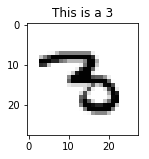

In [21]:
def show_digit(img, caption =''):
    plt.rcParams["figure.figsize"] = (2,10)
    plt.imshow(img.reshape(28,28), cmap="Greys",  interpolation='nearest')
    plt.title(caption)
    
show_digit(train_set[0][30],'This is a {}'.format(train_set[1][30]))

### Preprocessing the data
* Amazon SageMaker implementation of Linear Learner only takes recordIO-wrapped protobuf
* Define arrays to store image vectors and labels in float format

In [22]:
vectors = np.array(train_set[0]).astype('float32')
vectors.shape

(50000, 784)

#### If a label matches 3, redefine it as 1 and all other labels as 0. 

In [23]:
#Storing the labels in the form numpy array with data as type as float32.
labels = np.where(train_set[1] == 3, 1, 0).astype('float32')
labels.shape

(50000,)

In [25]:
labels[:20]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

### Converting input data to recordIO-wrapped protobuf
* creating IOBuffer to write the data in memory buffer and store on the tensor
* invoke method to convert the training data into the protobuf format
* move to the start of the buffer

In [32]:
buf = io.BytesIO()

In [33]:
smac.write_numpy_to_dense_tensor(buf, vectors, labels)

In [34]:
buf.seek(0)

0

## Move the training data and labels to S3 bucket

* Construct bucket path by specifying bucket name and prefix
* Define a key, the object reference to the unique identifier within a bucket
* Create bucket resource and upload buffer
* Set up path where output of our model is stored

In [35]:
bucket = 'loonybucket'  
prefix = 'sagemaker/linear-mnist'  

In [36]:
key = 'recordio-pb-data'

In [37]:
resource= boto3.resource('s3')

In [38]:
bucket_obj=resource.Bucket(bucket)

In [39]:
object_res=bucket_obj.Object(os.path.join(prefix, 'train', key))

In [40]:
train_data_loc = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(train_data_loc))

Uploaded training data location: s3://loonybucket/sagemaker/linear-mnist/train/recordio-pb-data


In [41]:
object_res.upload_fileobj(buf)

In [42]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://loonybucket/sagemaker/linear-mnist/output


## Specifying the Algorithm

* Get the region of the current notebook instance
* Built-in algorithms are specified in containers. Specify the algorithm container to be used. 
* Instantiate a session to access sagemaker.
* Get the role ARN whose credentials are used to call the API to instantiate the estimator
* Initialize an Estimator instance and specify the container, role, instance count and type, output location and session

In [43]:
region = boto3.Session().region_name
region

'us-east-2'

In [44]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}
container = containers[region]

In [45]:
sess = sagemaker.Session()

In [46]:
role = get_execution_role()
role

'arn:aws:iam::324118574079:role/service-role/AmazonSageMaker-ExecutionRole-20180209T192191'

In [47]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)

### Tuning parameters for the performace.
* Images are in the dimensions of 28 X 28 = 784.
* Predictor type is binary classifier. Other accepted value is regressor.
* Set the batch size

In [48]:
linear.set_hyperparameters(feature_dim=784,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

## Training and hosting the Model 
* Train a model using the input training dataset.The fit API calls the Amazon SageMaker CreateTrainingJob API to start model training. The API uses configuration you provided to create the estimator and the specified input training data to send the CreatingTrainingJob request to Amazon SageMaker.This is a synchronous operation. 

* After the model training successfully completes, call the deploy() method to host the model using the Amazon SageMaker hosting services.
* Initialize a predictor object to make prediction requests to an Amazon SageMaker endpoint.

In [49]:
linear.fit({'train': train_data_loc})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-03-08-11-04-25-096


.....................................................................
Docker entrypoint called with argument(s): train
[03/08/2018 11:10:01 INFO 139650080663360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'early_stopping_patience': u'3', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'early_stopping_tolerance': u'0.001', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_classifier_model_selection_criteria': u'accuracy', u'use_lr_scheduler'

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.09646111627578735, "sum": 0.09646111627578735, "min": 0.09646111627578735}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507415.341246, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1520507415.341172}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.09569513759613037, "sum": 0.09569513759613037, "min": 0.09569513759613037}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507415.341322, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1520507415.341306}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "ma

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08908711588859558, "sum": 0.08908711588859558, "min": 0.08908711588859558}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507421.974529, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1520507421.974454}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08985158941268921, "sum": 0.08985158941268921, "min": 0.08985158941268921}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507421.974605, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1520507421.97459}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0861534283733368, "sum": 0.0861534283733368, "min": 0.0861534283733368}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507428.601184, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1520507428.601098}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08778175813674927, "sum": 0.08778175813674927, "min": 0.08778175813674927}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507428.601287, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1520507428.601261}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max":

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08408354892730713, "sum": 0.08408354892730713, "min": 0.08408354892730713}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507435.045779, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1520507435.045706}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08657575304031372, "sum": 0.08657575304031372, "min": 0.08657575304031372}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507435.045866, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1520507435.045845}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "ma

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08258299269676209, "sum": 0.08258299269676209, "min": 0.08258299269676209}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507441.550683, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1520507441.550608}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08607004860877991, "sum": 0.08607004860877991, "min": 0.08607004860877991}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507441.550771, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1520507441.550748}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "ma

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08150941736221314, "sum": 0.08150941736221314, "min": 0.08150941736221314}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507448.083298, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1520507448.083224}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08567238028526306, "sum": 0.08567238028526306, "min": 0.08567238028526306}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507448.083378, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1520507448.083362}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "ma

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08072245624542236, "sum": 0.08072245624542236, "min": 0.08072245624542236}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507454.410058, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1520507454.409982}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08536105916023254, "sum": 0.08536105916023254, "min": 0.08536105916023254}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507454.410145, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1520507454.410123}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "ma

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08008822462081909, "sum": 0.08008822462081909, "min": 0.08008822462081909}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507460.935229, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1520507460.935154}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08507766467094421, "sum": 0.08507766467094421, "min": 0.08507766467094421}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507460.935306, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1520507460.935291}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "ma

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.07959234417915344, "sum": 0.07959234417915344, "min": 0.07959234417915344}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507467.553333, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1520507467.553259}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.08484374375343323, "sum": 0.08484374375343323, "min": 0.08484374375343323}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1520507467.553412, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1520507467.553394}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "

===== Job Complete =====


In [52]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2018-03-08-11-15-56-343
INFO:sagemaker:Creating endpoint with name linear-learner-2018-03-08-11-04-25-096


--------------------------------------------------------------------------------------------------------------!

## Validate the model for use. 
* Set the invocation’s 'ContentType', overriding any content_type from the serializer
* Specify how to serialize requests and deserialize responses that are specific to the algorithm.
* Serializer accepts a single argument, the input data, and returns a sequence of bytes. 
* Content type options for Amazon SageMaker algorithm inference requests include: text/csv, application/json, and application/x-recordio-protobuf. 
* Deserializer accepts two arguments, the result data and the response content type, and returns a sequence of bytes.
* Amazon SageMaker algorithms return JSON.

In [53]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

### Try getting a prediction for a single record.

In [54]:
result = linear_predictor.predict(train_set[0][30])
print(result)

{'predictions': [{'score': 0.772477924823761, 'predicted_label': 1.0}]}


### Running the model on the whole test set. 
* Split the test set array into multiple sub-arrays of length 100 each
* Hit the endpoint with each sub-array using the predictor object
* Results array will contain predicted label and socres for each prediction
* Store all predicted labels into a numpy array, predictions.

In [65]:
batched_test_set = np.array_split(test_set[0], 100)

In [67]:
print(len(test_set[0]))
print(len(batched_test_set))

10000
100


In [68]:
batched_test_set[0].shape

(100, 784)

In [69]:
predictions = []
for array in batched_test_set:
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

In [72]:
result

{'predictions': [{'predicted_label': 0.0, 'score': 0.01376094575971365},
  {'predicted_label': 0.0, 'score': 0.0005800220533274114},
  {'predicted_label': 0.0, 'score': 1.6669851902406663e-05},
  {'predicted_label': 0.0, 'score': 0.0050621978007256985},
  {'predicted_label': 0.0, 'score': 0.0004427969688549638},
  {'predicted_label': 0.0, 'score': 0.0007877496536821127},
  {'predicted_label': 0.0, 'score': 2.1889141862629913e-05},
  {'predicted_label': 0.0, 'score': 0.0004416278679855168},
  {'predicted_label': 0.0, 'score': 5.718477950722445e-06},
  {'predicted_label': 0.0, 'score': 7.135549822123721e-05},
  {'predicted_label': 0.0, 'score': 0.005323868244886398},
  {'predicted_label': 0.0, 'score': 3.50565678672865e-05},
  {'predicted_label': 0.0, 'score': 0.016314180567860603},
  {'predicted_label': 0.0, 'score': 9.619886986911297e-05},
  {'predicted_label': 1.0, 'score': 0.8712612390518188},
  {'predicted_label': 0.0, 'score': 3.12837291858159e-05},
  {'predicted_label': 0.0, 'scor

In [78]:
predictions[:50]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.])

In [74]:
predictions = np.array(predictions)

## Creating the confusion matrix
* Use the pandas crosstab method to compute a frequency table of two factors
* actual: contains the actual times a label id 3 in the test dataset
* predictions: contains the predictions made by our model
* The crosstab method checks the times the label in our predictions and those in the test data set matches.

In [75]:
actual = np.where(test_set[1] == 3, 1, 0)

In [76]:
pd.crosstab(actual, predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,8913,77
1,151,859


### Delete the endpoint when you are done.

In [ ]:
sess.delete_endpoint(linear_predictor.endpoint)